In [1]:
%load_ext autoreload
%autoreload 2

In [16]:
import os
from joblib import parallel_backend

import pandas as pd
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV

from chesswinnerprediction.baseline.utils import (
    get_x_and_y,
    get_class_weights,
    print_report,
    show_feature_importance,
    transform_and_scale_df,
    get_worst_params_df,
)
from chesswinnerprediction.baseline.constants import BASELINE_RANDOM_STATE
from chesswinnerprediction.constants import PROCESSED_FOLDER_PATH

In [3]:
data_dir = "lichess_db_standard_rated_2017-05"
data_path = os.path.join(PROCESSED_FOLDER_PATH, data_dir)

In [4]:
train_df = pd.read_csv(os.path.join(data_path, "train.csv"))
valid_df = pd.read_csv(os.path.join(data_path, "valid.csv"))

In [5]:
std_scaler = StandardScaler()
train_data = transform_and_scale_df(train_df, std_scaler)
valid_data = transform_and_scale_df(valid_df, std_scaler, fit_scale=False)

In [6]:
class_weights = get_class_weights(train_df["Result"], verbose=True)

Class weights:
	1-0: 0.6719252445731612
	0-1: 0.6972429817947734
	1/2-1/2: 12.900070154830079


In [7]:
x_train_data, y_train = get_x_and_y(train_data, predict_draws=True)
x_valid_data, y_valid = get_x_and_y(valid_data, predict_draws=True)

## Random Forest

In [8]:
random_forest_params = {
    "n_estimators": [24, 32, 56],
    "max_depth": [10, 11, 12],
    "max_features": ["sqrt", 0.5],
    "min_samples_split": [7e-5, 13e-5, 25e-5, 50e-5],
    "min_samples_leaf": [1e-5, 3e-5, 8e-5, 12e-5],
    "min_impurity_decrease": [5e-6, 1e-5, 1e-4, 2e-4],
    "min_weight_fraction_leaf": [0.0, 1e-5, 2e-5, 5e-5],
    "max_leaf_nodes": [None, 350, 400, 450],
}

forest_clf = RandomForestClassifier(
    class_weight=class_weights, verbose=0, n_jobs=-1, random_state=BASELINE_RANDOM_STATE
)

random_search = RandomizedSearchCV(
    estimator=forest_clf,
    param_distributions=random_forest_params,
    n_iter=15,
    cv=5,
    verbose=3,
    random_state=BASELINE_RANDOM_STATE,
    scoring="recall_macro",
    return_train_score=True,
)

In [9]:
_ = random_search.fit(x_train_data, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV 1/5] END max_depth=12, max_features=0.5, max_leaf_nodes=None, min_impurity_decrease=0.0001, min_samples_leaf=3e-05, min_samples_split=7e-05, min_weight_fraction_leaf=1e-05, n_estimators=24;, score=(train=0.473, test=0.465) total time=   9.3s
[CV 2/5] END max_depth=12, max_features=0.5, max_leaf_nodes=None, min_impurity_decrease=0.0001, min_samples_leaf=3e-05, min_samples_split=7e-05, min_weight_fraction_leaf=1e-05, n_estimators=24;, score=(train=0.475, test=0.468) total time=   8.0s
[CV 3/5] END max_depth=12, max_features=0.5, max_leaf_nodes=None, min_impurity_decrease=0.0001, min_samples_leaf=3e-05, min_samples_split=7e-05, min_weight_fraction_leaf=1e-05, n_estimators=24;, score=(train=0.472, test=0.471) total time=   8.2s
[CV 4/5] END max_depth=12, max_features=0.5, max_leaf_nodes=None, min_impurity_decrease=0.0001, min_samples_leaf=3e-05, min_samples_split=7e-05, min_weight_fraction_leaf=1e-05, n_estimators=24;, score=(t

In [10]:
print(f"Best Score: {random_search.best_score_}")
print(f"Best Parameters: {random_search.best_params_}")

Best Score: 0.467340121447312
Best Parameters: {'n_estimators': 24, 'min_weight_fraction_leaf': 1e-05, 'min_samples_split': 7e-05, 'min_samples_leaf': 3e-05, 'min_impurity_decrease': 0.0001, 'max_leaf_nodes': None, 'max_features': 0.5, 'max_depth': 12}


Let's take a look at the worst parameters.

In [17]:
get_worst_params_df(random_search.cv_results_).head(5)

,,,,,,,,mean_test_score
param_n_estimators,param_min_weight_fraction_leaf,param_min_samples_split,param_min_samples_leaf,param_min_impurity_decrease,param_max_leaf_nodes,param_max_features,param_max_depth,


In [18]:
best_forest_clf = random_search.best_estimator_.fit(x_train_data, y_train)

In [19]:
print_report(best_forest_clf, x_train_data, y_train, x_valid_data, y_valid)

						 Train Report 									 Validation Report
              precision    recall  f1-score   support         precision    recall  f1-score   support
         0-1       0.62      0.38      0.47    378005              0.61      0.38      0.47     45215
         1-0       0.60      0.45      0.52    392248              0.60      0.46      0.52     47511
     1/2-1/2       0.05      0.57      0.08     20431              0.05      0.56      0.09      2537
    accuracy                           0.42    790684                                  0.43     95263
   macro avg       0.42      0.47      0.36    790684              0.42      0.47      0.36     95263
weighted avg       0.59      0.42      0.49    790684              0.59      0.43      0.49     95263
       


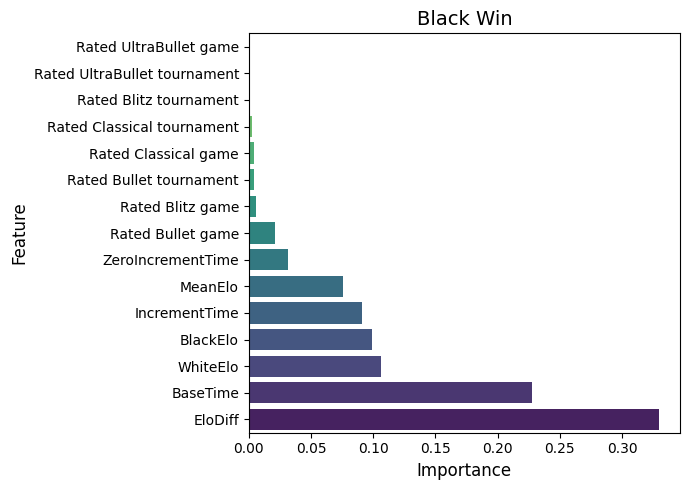

In [20]:
feature_importance = best_forest_clf.feature_importances_.reshape(1, -1)
show_feature_importance(best_forest_clf, feature_importance)

## Gradient Boosting

In [68]:
gradient_boosting_params = {
    "n_estimators": [10, 15, 20],
    "max_depth": [2, 3, 4],
    "max_features": ["sqrt", 0.5],
    "learning_rate": [0.1, 0.05],
    "tol": [0.1],
    # "min_samples_split": [3e-5, 7e-5, 13e-5, 25e-5],
    # "min_samples_leaf": [1e-5, 3e-5, 8e-5, 12e-5],
    # "min_impurity_decrease": [1e-5, 1e-4, 2e-4],
    "min_weight_fraction_leaf": [1e-4, 2e-4, 5e-4],
}

boosting_clf = GradientBoostingClassifier(verbose=0, validation_fraction=0.1)

random_search = RandomizedSearchCV(
    estimator=boosting_clf,
    param_distributions=gradient_boosting_params,
    n_iter=3,
    cv=5,
    verbose=3,
    random_state=42,
    scoring="recall_macro",
    return_train_score=True,
    # pre_dispatch=7,
    n_jobs=-1,
)

In [69]:
with parallel_backend("multiprocessing"):
    random_search.fit(x_train_data, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
[CV] END learning_rate=0.1, max_depth=2, max_features=0.5, min_weight_fraction_leaf=0.0001, n_estimators=15, tol=0.1; total time=  38.0s
[CV] END learning_rate=0.1, max_depth=2, max_features=0.5, min_weight_fraction_leaf=0.0001, n_estimators=15, tol=0.1; total time=  38.2s
[CV] END learning_rate=0.1, max_depth=2, max_features=0.5, min_weight_fraction_leaf=0.0001, n_estimators=15, tol=0.1; total time=  40.8s
[CV] END learning_rate=0.05, max_depth=3, max_features=sqrt, min_weight_fraction_leaf=0.0002, n_estimators=20, tol=0.1; total time=  43.4s
[CV] END learning_rate=0.05, max_depth=3, max_features=sqrt, min_weight_fraction_leaf=0.0002, n_estimators=20, tol=0.1; total time=  43.4s
[CV] END learning_rate=0.05, max_depth=3, max_features=sqrt, min_weight_fraction_leaf=0.0002, n_estimators=20, tol=0.1; total time=  44.8s
[CV] END learning_rate=0.05, max_depth=3, max_features=sqrt, min_weight_fraction_leaf=0.0002, n_estimators=20, t

In [71]:
print(f"Best Score: {random_search.best_score_}")
print(f"Best Parameters: {random_search.best_params_}")

Best Score: 0.40166798435450213
Best Parameters: {'tol': 0.1, 'n_estimators': 15, 'min_weight_fraction_leaf': 0.0001, 'max_features': 0.5, 'max_depth': 2, 'learning_rate': 0.1}


In [72]:
get_worst_params_df(random_search.cv_results_).head(5)

mean_test_score
param_tol param_n_estimators param_min_weight_fraction_leaf param_max_features param_max_depth param_learning_rate                 
0.1       15                 0.0002                         sqrt               2               0.10                        0.400181
          20                 0.0002                         sqrt               3               0.05                        0.400329
          15                 0.0001                         0.5                2               0.10                        0.401668

In [73]:
best_boosting_clf = random_search.best_estimator_.fit(x_train_data, y_train)

In [74]:
print_report(best_boosting_clf, x_train_data, y_train, x_valid_data, y_valid)

						 Train Report 									 Validation Report
              precision    recall  f1-score   support         precision    recall  f1-score   support
         0-1       0.59      0.54      0.56    378005              0.59      0.53      0.56     45215
         1-0       0.58      0.67      0.62    392248              0.58      0.67      0.62     47511
     1/2-1/2        nan      0.00      0.00     20431               nan      0.00      0.00      2537
    accuracy                           0.59    790684                                  0.59     95263
   macro avg       0.59      0.40      0.40    790684              0.59      0.40      0.39     95263
weighted avg       0.59      0.59      0.58    790684              0.59      0.59      0.58     95263
       


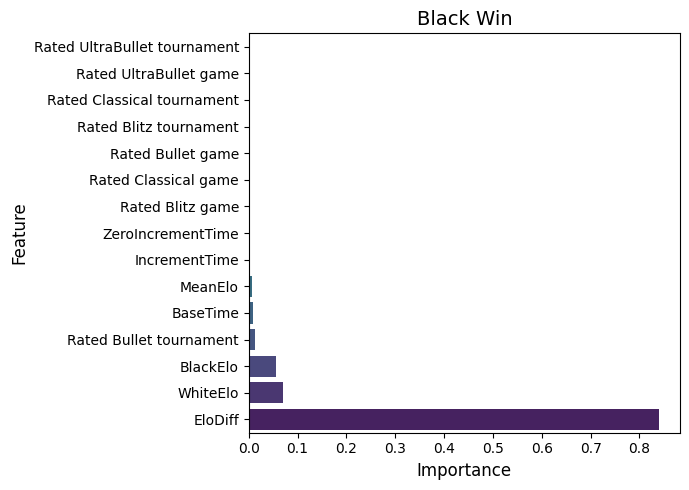

In [75]:
feature_importance = best_boosting_clf.feature_importances_.reshape(1, -1)
show_feature_importance(best_boosting_clf, feature_importance)